**ML COURSE 2024-2025**
# LAB5: DECISION TREES AND FORESTS
In this lab you will see implementations of a Decision Tree and a Random Forest, as well as how to use other forest-based models. 

In [ ]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from matplotlib import pyplot as plt

from utils import stratified_train_test_split, accuracy

## Decision Tree Classifier

### Implementation from scratch

Nodes indexing:

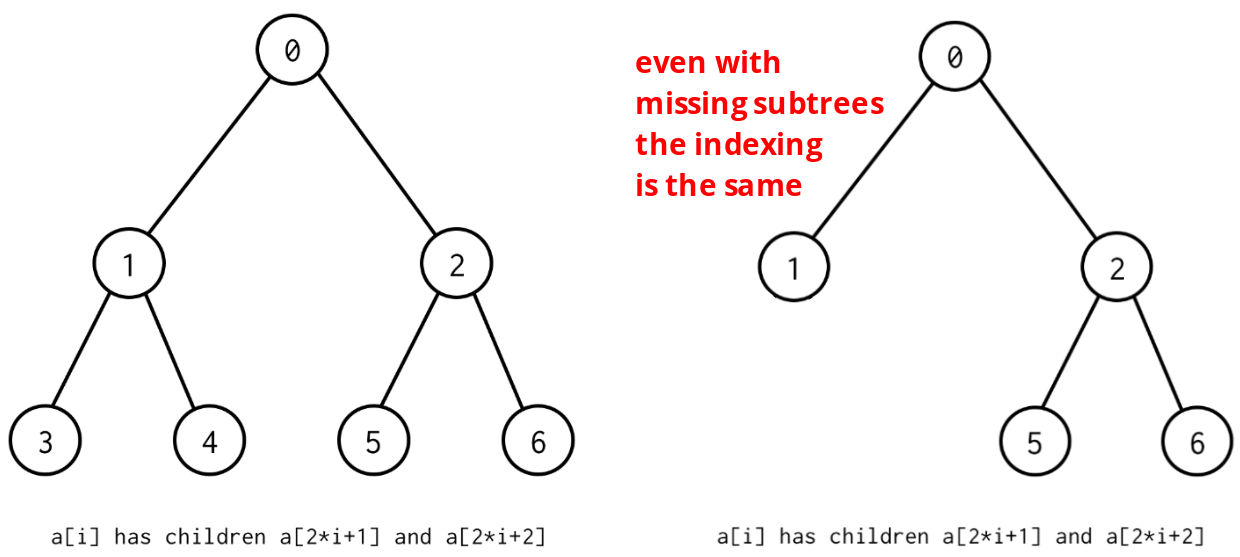

Decision Tree:

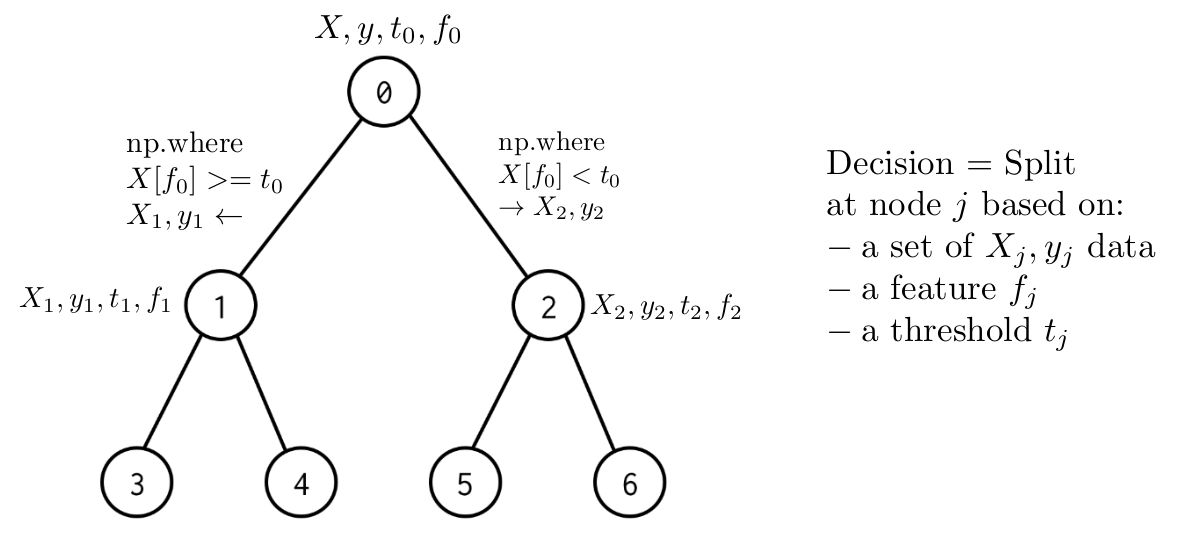

For each criterion, we define a class with fundamental attributes/methods:

0. **`OPTIMIZATION`**: this is an attribute (in this case a string) and defines whether we want to minimize or maximize the impurity.
1. **`impurity()`**: this method calculates a score on a vector of target values.
2. **`split_impurity()`**: this method calculates the impurity of a split, meaning the impurity of two arrays of target values, one for each side of the split.
3. **`is_tolerance_reached()`**: this method checks if the improvement of impurity of a split is below a certain threshold.

Note that based on the criterium, we may have different optimization targets, for example:
- in the case of **Gini impurity**, we want to **minimize** the impurity
- while in the case of **information gain**, we want to **maximize** it

In [ ]:
# We can define a base class for the criterion, which tells us how a criterion should be defined

# You can think of this as a "blueprint" to neatly define different criteria, we can also specify
# the type of returned values for each method with a little arrow next to the method name like: -> float

class Criterion:
    OPTIMIZATION = ""

    @staticmethod
    def impurity(y) -> float: ...

    @staticmethod
    def split_impurity(y_left, y_right) -> float: ...

    @staticmethod
    def is_tolerance_reached(node_impurity, split_impurity, min_improvement) -> bool: ...

The Gini impurity is defined as:
$$
Gini(p) = 1 - \sum_{i=1}^{C} p_i^2
$$
where $p_i$ is the proportion of samples in class $i$ and $C$ is the number of classes.

In [ ]:
# The class is used to group functions, neatly packaged together, this makes the code more readable.

# We could have defined normal functions like gini_impurity(...), gini_split_impurity(...), etc.
# but that could become cumbersome if we have many other criteria.

# @staticmethod means that methods work by themselves, just like normal functions

# Adding Criterion in parentheses to tell Python that the base structure of the class is the one we defined before
class GiniCriterion(Criterion): 
    OPTIMIZATION = "minimize"

    @staticmethod
    def impurity(y): 
        """Gini impurity is the squared sum of the proportion/probability of each class"""
        class_counts = np.unique(y, return_counts=True)[1]
        probs = class_counts / len(y)
        return 1 - np.sum(probs ** 2)

    @staticmethod 
    def split_impurity(y_left, y_right): 
        """Weighted sum of the gini impurity of two subsets"""
        nL = len(y_left)
        nR = len(y_right)
        n = nL + nR
        g_left = GiniCriterion.impurity(y_left)
        g_right = GiniCriterion.impurity(y_right)
        return (nL * g_left + nR * g_right) / n
    
    @staticmethod 
    def is_tolerance_reached(node_impurity, split_impurity, min_improvement): 
        improvement = node_impurity - split_impurity
        return improvement < min_improvement


Let's see an example of usage of the Criterion class (Gini in this case).

In [ ]:
# Define an example of targets
y1 = np.array(["cat", "cat", "dog", "dog", "dog"])

# Access the methods of the class using the class name and the dot operator
impurity = GiniCriterion.impurity(y1)
print(f"Gini impurity of y1 is {impurity:.2f}")

y2 = np.array(["cat", "cat"])
impurity = GiniCriterion.impurity(y2)
print(f"Gini impurity of y2 is {impurity:.2f}")

total_impurity = GiniCriterion.impurity(np.concatenate((y1, y2)))
print(f"Gini impurity of y = concat(y1, y2) is {total_impurity:.2f}")

split_impurity = GiniCriterion.split_impurity(y1, y2)
print(f"Gini impurity of the split (y1, y2) is: {split_impurity:.2f}")

A tree is in essence a set of rules that are applied to the data. We have to store the rules in a way that we can easily access them.

A typical way to implement a tree is by defining a set of nodes that are related to eachother, so we also define a class `Node`. 

In [ ]:
# In this case, the class is just a bundle of variables, neatly packed together

@dataclass 
class Node: 
    impurity: float | None          # None if leaf
    split_impurity: float | None    # None if leaf
    feature: int | None             # None if leaf
    threshold: float | None         # None if leaf
    prediction: float | None        # None if not leaf
    n_samples: int

Let's see an example of a node object.

In [ ]:
# In this case we create an object of the class Node, since it has to store information
node = Node(impurity=0.5, split_impurity = 0.3, feature=1, threshold=0.5, prediction=None, n_samples=10)

# Access the attributes of the node with the dot operator
print(f"Impurity: {node.impurity}, Split Impurity: {node.split_impurity}, Feature: {node.feature}, Threshold: {node.threshold}, Prediction: {node.prediction}, Samples: {node.n_samples}")

In this first implementation, we will study the **Decision Tree Classifier**, so the prediction will be a class label.

Given a **leaf node** (a node with no children, so no further splits), we will assign a class label to it. 

The predicted label is most common class in the samples that reach that node during the training phase.

In [ ]:
# to make the class as general as possible, we define outside the 'node_prediction' function
def node_prediction_classification(y): 
    """Return the most common class in the node"""
    classes, counts = np.unique(y, return_counts=True)
    return classes[np.argmax(counts)]

Now we are ready to define the class of our decision tree classifier model.

In [ ]:
from typing import Type


class DecisionTree: 
    def __init__(self, criterion: Type[Criterion], node_pred_fnc, max_depth, min_impurity_improvement): 
        """
        Args: 
            criterion: class of the impurity criterion as defined above
            node_pred_fnc: function to predict the class of a node, that takes as input y and return the prediction
            max_depth: maximum depth of the tree
            min_impurity_improvement: minimum impurity improvement to split a node
        """
        # we define here this attribute to share across all the methods 
        self.criterion = criterion
        self.node_pred_fnc = node_pred_fnc
        self.max_depth = max_depth
        self.min_impurity_improvement = min_impurity_improvement

        # attributes to be set in fit method
        self.categorical_feat_idxs = []
        self.nodes = dict()

    @staticmethod
    def _split_dataset(X, feature, threshold, is_categorical): 
        if is_categorical:
            # categorical feature 
            left_mask = X[:, feature] == threshold
            right_mask = X[:, feature] != threshold
        else:
            # numerical feature
            left_mask = X[:, feature] <= threshold
            right_mask = X[:, feature] > threshold
        return left_mask, right_mask
   
    @staticmethod
    def _child_id(node_id, is_left): 
        if is_left: 
            return 2 * node_id + 1
        else:
            return 2 * node_id + 2
        
    def _find_best_split(self, X, y): 
        """Find the best feature and threshold to split the data"""
        n_features = X.shape[1]

        best_feature:int = -1
        best_threshold:float = 0.0
        best_impurity = np.inf if self.criterion.OPTIMIZATION == "minimize" else -np.inf

        # iterate over features 
        for f in range(n_features):
            is_categorical = f in self.categorical_feat_idxs
            split_impurity, threshold = self._find_best_threshold(X[:, f], y, is_categorical)
            
            if self.criterion.OPTIMIZATION == "minimize":
                is_better = split_impurity < best_impurity  # minimize
            else: 
                is_better = split_impurity > best_impurity  # maximize

            if is_better:
                    best_feature = f
                    best_threshold = threshold
                    best_impurity = split_impurity
        
        return best_impurity, best_feature, best_threshold
    
    def _find_best_threshold(self, X_f, y, is_categorical): 
        """Try all possible thresholds/categories and return the best one"""
        unique_values = np.unique(X_f) 
        best_impurity = np.inf if self.criterion.OPTIMIZATION == "minimize" else -np.inf

        if len(unique_values) < 2:
            return best_impurity, unique_values[0]  # no split possible
        
        for value in unique_values: 
            # divide according to threshold/category
            left_mask, right_mask = self._split_dataset(X_f, ..., value, is_categorical)
            y_left, y_right = y[left_mask], y[right_mask]

            # skip if the value does not split the data
            if len(y_left) == 0 or len(y_right) == 0: 
                continue   

            # evaluate impurity of the split
            split_impurity = self.criterion.split_impurity(y_left, y_right)

            if self.criterion.OPTIMIZATION == "minimize":
                is_better = split_impurity < best_impurity  # minimize
            else:
                is_better = split_impurity > best_impurity  # maximize

            if is_better:
                best_impurity = split_impurity
                best_threshold = value
                    
        return best_impurity, best_threshold

    def _build_tree(self, X, y, depth, node_id): 
        """Construct recursively the tree"""
        n_samples_node = len(y)

        # -- LEAF CONDITIONS ---
        # 0. All the feature values of all the samples are the same (no useful split possible)
        # 1. The node has 0 or 1 samples (no split possible)
        # 2. Max depth is reached
        # 3. The impurity improvement < min_impurity_improvement (implemented after)

        # (leaf condition 0)
        X_all_same = all(len(np.unique(X[:, feat])) == 1 for feat in range(X.shape[1]))

        if len(y) <= 1 or depth >= self.max_depth or X_all_same: 
            prediction = self.node_pred_fnc(y)
            self.nodes[node_id] = Node(None, None, None, None, prediction, n_samples_node)    # leaf node
            return

        # -- Internal Node: find best split and create children --
        best_split_impurity, best_feature, best_threshold = self._find_best_split(X, y)

        # (leaf condition 3)
        current_node_impurity = self.criterion.impurity(y)
        if self.criterion.is_tolerance_reached(current_node_impurity, best_split_impurity, self.min_impurity_improvement):
            prediction = self.node_pred_fnc(y)
            self.nodes[node_id] = Node(None, None, None, None, prediction, n_samples_node)    # leaf node
            return
        # -- Save node --
        self.nodes[node_id] = Node(current_node_impurity, best_split_impurity, best_feature, best_threshold, None, n_samples_node)

        # -- Create children -- 
        is_feat_cat = best_feature in self.categorical_feat_idxs
        left_mask, right_mask = self._split_dataset(X, best_feature, best_threshold, is_feat_cat)

        left_id = self._child_id(node_id, True)
        right_id = self._child_id(node_id, False)

        X_left, y_left = X[left_mask], y[left_mask]
        self._build_tree(X_left, y_left, depth + 1, left_id)

        X_right, y_right = X[right_mask], y[right_mask]
        self._build_tree(X_right, y_right, depth + 1, right_id)

    def fit(self, X, y, categorical_feat_idxs = None): 
        """
        Fit the decision tree to the data. The tree is built recursively by splitting the data at each node
        based on the impurity criterion. 
        Args: 
            X: input matrix of shape (n_samples, n_features)
            y: true target/labels of shape (n_samples,)
            categorical_feat_idxs: list of categorical feature indices
        """
        self.categorical_feat_idxs = categorical_feat_idxs if categorical_feat_idxs is not None else []

        self.nodes = dict()     # Reset the nodes
        self._build_tree(X, y, 0, 0)
        
    def predict(self, X): 
        """
        Predict the target variable for the given input data X. 
        Keep the same column order as in the training data. 
        
        Args: 
            X: input matrix of shape (n_samples, n_features)
        """
        predictions = []
        for x in X: 
            node_id = 0
            node : Node = self.nodes[0]
            while True: 
                if node.prediction is not None: 
                    predictions.append(node.prediction) # leaf node
                    break
                # else we need to go down the tree
                if node.feature in self.categorical_feat_idxs: 
                    # categorical features
                    is_left = x[node.feature] == node.threshold
                else:
                    # continuous features
                    is_left = x[node.feature] <= node.threshold
                node_id = self._child_id(node_id, is_left)
                node = self.nodes[node_id]
        return np.array(predictions)
    

    def print_tree(self, node_id=0, prefx="", is_left=True, feat_names=None):
        """
        Prints the binary tree in a hierarchical format.
        """
        if node_id not in self.nodes:
            return

        node = self.nodes[node_id]
        conn = "├── " if is_left else "└── "

        if node.feature is None:
            print(f"{prefx}{conn}{node_id}-Pred: {node.prediction}")
            return
        else:
            if feat_names is None:
                f = f"X[{node.feature}]"
            else:
                f = feat_names[node.feature]
            print(f"{prefx}{conn}{node_id}-{f} <= {node.threshold} | Impurity:{node.impurity:.3f}")

        prefx += "│   " if is_left else "    "
        l_id = self._child_id(node_id, is_left=True)
        r_id = self._child_id(node_id, is_left=False)

        self.print_tree(l_id, prefx, is_left=True, feat_names=feat_names)
        self.print_tree(r_id, prefx, is_left=False, feat_names=feat_names)

### Decision Tree Classification on IRIS

In [ ]:
data = pd.read_csv('drive/MyDrive/AA24-25ML/iris.csv')
display(data.head())

feature_names = data.columns[:-1]
target_col = 'species'

X = data.drop(target_col, axis=1).to_numpy()
y = data[target_col].to_numpy()

print("X.shape_", X.shape, "y.shape_", y.shape)

In [ ]:
# define model using the Gini impurity criterion
tree = DecisionTree(criterion=GiniCriterion, 
                    node_pred_fnc = node_prediction_classification, 
                    max_depth = 3,
                    min_impurity_improvement=0.0)

Let's test our class and find the best first split

In [ ]:
best_gini, best_feature, best_threshold = tree._find_best_split(X, y)
print(f"Best gini impurity for the first split: {best_gini:.2e}")
print(f"Best feature: '{feature_names[best_feature]}'")
print(f"Best threshold: {best_threshold:.2f}")

plt.scatter(X[:, best_feature], y)
plt.axvline(best_threshold, color="red", linestyle="--")
plt.xlabel(feature_names[best_feature])
plt.ylabel("species")
plt.title(f"Best split for '{feature_names[best_feature]}' feature")


Find and test the binary decision tree

In [ ]:
# fit the model
tree.fit(X, y, categorical_feat_idxs = None) 

In [ ]:
# print the tree
tree.print_tree()

In [ ]:
# training prediction and accuracy
y_pred = tree.predict(X)
print("Training accuracy:", accuracy(y, y_pred))

Visualize the decision boundary

In [ ]:
from utils import plot_decision_boundary_2d, create_2d_meshpoints

def create_proba(dtree):
    def tree_proba(X):
        y_pred = dtree.predict(X)
        y_pred = np.unique(y_pred, return_inverse=True)[1]
        proba = np.zeros((X.shape[0], len(np.unique(y))))
        for i, pred in enumerate(y_pred):
            proba[i, pred] = 1
        return proba
    return tree_proba

max_depth = 4
print("Max depth:", max_depth)
tree2 = DecisionTree(GiniCriterion, node_prediction_classification, max_depth, 0.0)
tree2.fit(X, y, categorical_feat_idxs=None) 
y_pred = tree2.predict(X)
print("Train Accuracy:", accuracy(y, y_pred))
                     

X_grid, xx, yy, X_2d = create_2d_meshpoints(X, 200)

probability_func = create_proba(tree2)

n_features = X.shape[1]
plot_decision_boundary_2d(
    X_grid,
    np.unique(y, return_inverse=True)[1],
    probability_func,
    xx,
    yy,
    X_2d,
    n_features,
)

### Decision Tree Classifier on Wine

In [ ]:
from sklearn import datasets
from sklearn.utils import shuffle

wine = datasets.load_wine()
assert not isinstance(wine, tuple) # optional: check that it's not a tuple
print(wine.keys())

# 'data': np array of shape (178 samples, 13 features), containing the data.
# 'target': np array of shape (178 samples,) containing class labels (0, 1, or 2).
# 'frame': not used, set to None. (in some datasets, it contains the csv file path)
# 'target_names': np array of shape (3,) containing the class labels (['class_0' 'class_1' 'class_2']).
# 'DESCR': string containing the description of the dataset.
# 'feature_names': np array of shape (13,) containing the feature names.

# It's still a tabular dataset, but instead of having the table stored in a csv file, 
# it's stored in a dictionary as a numpy array (data) and a numpy array (target) for the labels (+ additional information)


# shuffle the data to make sure that the classes are not ordered in any way
np.random.seed(0)
X, y = shuffle(wine["data"], wine["target"], random_state=0)

# divide in train and test set stratified
X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, train_prop=0.8)

In [ ]:
max_depths = [1,2,3]
for max_depth in max_depths: 
    print("Max depth: ", max_depth)
    tree = DecisionTree(GiniCriterion, node_prediction_classification, max_depth, 0.0)
    tree.fit(X_train, y_train, categorical_feat_idxs=None)
    y_pred = tree.predict(X_test)
    print("  Test accuracy:", accuracy(y_test, y_pred))

In [ ]:
# decision boundaries 
for max_depth in max_depths: 
    tree = DecisionTree(GiniCriterion, node_prediction_classification, max_depth, 0.0)
    tree.fit(X_train, y_train, categorical_feat_idxs=None)

    X_grid, xx, yy, X_2d = create_2d_meshpoints(X, 200)

    probability_func = create_proba(tree)

    n_features = X_train.shape[1]
    plot_decision_boundary_2d(
        X_grid,
        np.unique(y, return_inverse=True)[1],
        probability_func,
        xx,
        yy,
        X_2d,
        n_features,
        title=f"Decision boundary | max_depth={max_depth}",
    )

### Post Hoc Pruning: Cost-Complexity Pruning

As in CART approach, we will use a post-hoc pruning method.

The idea is to prune the tree after it has been fully grown.

The pruning is done by removing subtrees that minimally improve the impurity of the tree.

> The impurity is calculated on a separate validation set.

In [ ]:
def compute_cost_complexity(X, y, node_id, tree, ccps, total_N):
    node = tree.nodes[node_id]

    # Compute node impurity
    node_impurity = tree.criterion.impurity(y) * len(y) / total_N

    if node.feature is None:  # Leaf node
        return node_impurity, 1  # (impurity, number of leaves)

    # This is a parent node: Split dataset and process children
    left_id = tree._child_id(node_id, is_left=True)
    right_id = tree._child_id(node_id, is_left=False)
    left_mask, right_mask = tree._split_dataset(
        X, node.feature, node.threshold, node.feature in tree.categorical_feat_idxs
    )

    left_impurity, left_leaves = compute_cost_complexity(
        X[left_mask], y[left_mask], left_id, tree, ccps, total_N
    )
    right_impurity, right_leaves = compute_cost_complexity(
        X[right_mask], y[right_mask], right_id, tree, ccps, total_N
    )

    total_leaves = left_leaves + right_leaves

    impurity_sum = left_impurity + right_impurity
    ccps[node_id] = (node_impurity - impurity_sum) / (total_leaves - 1)

    return impurity_sum, total_leaves

Iris example:

In [ ]:
# load the iris dataset
data = pd.read_csv("drive/MyDrive/AA24-25ML/iris.csv")
feature_names, target_col = data.columns[:-1], "species"
X = data.drop(target_col, axis=1).to_numpy()
y = data[target_col].to_numpy()

# define model using the Gini impurity criterion
tree = DecisionTree(
    criterion=GiniCriterion,
    node_pred_fnc=node_prediction_classification,
    max_depth=3,
    min_impurity_improvement=0.0,
)

# fit the model
tree.fit(X, y, categorical_feat_idxs=None)

subtrees_impurities = {}
compute_cost_complexity(X, y, 0, tree, subtrees_impurities, total_N=len(y))

# keep only the internal nodes
subtrees_impurities = {node_id: imp for node_id, imp in subtrees_impurities.items() if tree.nodes[node_id].feature is not None}


for node_id, imp in subtrees_impurities.items():  # Reusing the same impurity dictionary
    print(f"Subtree {node_id} imp: {imp:.4f}")

print("-" * 50)
tree.print_tree()

Now that we know the subtrees that less improve the impurity, we can prune them with the following function.

In [ ]:
# given the node_id, we can remove the node and all its children
# to get the prediction, we still need the training dataset
def prune_tree(X, y, node_id, tree, ids_to_prune):
    node = tree.nodes[node_id]

    if node_id in ids_to_prune:
        # Turn this node into a leaf
        tree.nodes[node_id] = Node(None, None, None, None, tree.node_pred_fnc(y), node.n_samples)
        return

    if node.feature is None:  # Leaf node
        return

    left_mask, right_mask = tree._split_dataset(
        X, node.feature, node.threshold, node.feature in tree.categorical_feat_idxs
    )
    left_id = tree._child_id(node_id, is_left=True)
    right_id = tree._child_id(node_id, is_left=False)
    prune_tree(X[left_mask], y[left_mask], left_id, tree, ids_to_prune)
    prune_tree(X[right_mask], y[right_mask], right_id, tree, ids_to_prune)

Let's see how the accuracy changes with varying the number of pruned subtrees.

In [ ]:
tree = DecisionTree(
    criterion=GiniCriterion,
    node_pred_fnc=node_prediction_classification,
    max_depth=3,
    min_impurity_improvement=0.0,
)

# order the ccps by increasing ccp
sorted_ccps = sorted(subtrees_impurities.items(), key=lambda x: x[1])
accuracies = []
for i in range(len(sorted_ccps)):
    nodes_to_prune = [node_id for node_id, _ in sorted_ccps[:i + 1]]
    print(f"Pruning nodes: {nodes_to_prune}")
    # start from the original tree
    tree.fit(X, y, categorical_feat_idxs=None)
    # prune the tree
    prune_tree(X, y, 0, tree, nodes_to_prune)
    # get the predictions
    y_pred = tree.predict(X)
    # compute the accuracy
    acc = accuracy(y, y_pred)
    print(f"Accuracy after pruning nodes {nodes_to_prune}: {acc:.4f}")
    # plot the tree
    tree.print_tree()
    print("-" * 50)
    accuracies.append((acc, len(nodes_to_prune)))

In [ ]:
accuracies = np.array(accuracies)
plt.plot(accuracies[:, 1], accuracies[:, 0], marker="o")
plt.xlabel("Number of pruned nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of pruned nodes")
plt.grid()

## Random Forest

Decision trees offer advantages in terms of interpretability and computational efficiency. However, relying on a **single tree** for classification can lead to **high variance** and overfitting.

To address this, we build an **ensemble** of multiple decision trees, known as a **forest**. Instead of training just one tree, we train several trees on **slightly different versions** of the training dataset. At test time, we predict the class that receives the majority vote across all trees.

What does **slightly different versions** of the training dataset mean?

Each tree in the forest is trained on a **randomly sampled subset** of the training data. This randomness introduces diversity among the trees, reducing variance and improving generalization.

### Bagging (Bootstrap Aggregating)

Bagging involves creating **bootstrap samples** from the original training dataset. This means:

- Given a dataset with $n$ samples, we randomly select $n$ samples **with replacement** to create a new training set.
- Since sampling is done **with replacement**, some samples may appear multiple times, while others may not appear at all.

A useful analogy:  
> Imagine an urn containing all the training samples. You randomly pick a sample, record it in the new dataset, then **return it to the urn** before drawing again. This process continues until you have selected $n$ samples.

Each tree in the forest is trained on a different bootstrap sample, ensuring variability in the dataset used for training.

In [ ]:
def bootstrap_sample(X, y):
    # select n samples from X with replacement
    # first parameter: values among which we are selecting, second parameter: number of values that we are 
    # selecting, third parameter: with replacement
    indices = np.random.choice(len(X), size=len(X), replace=True)
    # filter X and y based on indices
    return X[indices], y[indices]

def fit_bagging(X, y, T, max_depth): 
    """Fit T trees using bagging"""
    # forest
    trees = []
    for j in range(T): 
        # alternative dataset
        X_sample, y_sample = bootstrap_sample(X, y)
        # initialize the tree
        tree = DecisionTree(GiniCriterion, node_prediction_classification, max_depth, 0.0)
        # fit the tree
        tree.fit(X_sample, y_sample, categorical_feat_idxs=None)
        # add the tree to the forest
        trees.append(tree)
    return trees
    
def predict_bagging(X, trees): 
    # matrix where each row corresponds to a different tree (each column correspond to a different sample)
    predictions = np.array([tree.predict(X) for tree in trees]) # Shape (num_trees, num_samples)
    y_pred = []
    confidences = []
    # iterate through the columns
    for i in range(predictions.shape[1]):
        # for column (sample) i, consider all rows (all predictions of all trees)
        sample_predictions = predictions[:, i]
        # get the number of times each class appears in the column 
        # (array containing the number of times class 0 appears, the number of times class 1 appears ...)
        class_counts = np.bincount(sample_predictions)
        # get the class that appears most frequently
        majority_class = np.argmax(class_counts)
        # we compute the confidence interval as the proportion of times that the majority class gets predicted
        confidence = class_counts[majority_class] / len(trees)
        # add the prediction to the prediction list
        y_pred.append(majority_class)
        # add the confidence to the confidence list
        confidences.append(confidence)
    return np.array(y_pred), np.array(confidences)

In [ ]:
# number of trees in the forest
T = 4
# depth of each tree
max_depth = 2

accuracies = []

# train the forest
trees = fit_bagging(X_train, y_train, T, max_depth)
# get the vector of predictions
y_pred, confidences = predict_bagging(X_test, trees)
acc = accuracy(y_test, y_pred)
print("Accuracy: ", acc)
print("Predictions: ", y_pred)
print("True labels: ", y_test)
print("Confidence of the predictions: ", confidences)

In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        print("Index: ", i)
        print("Prediction: ", y_pred[i])
        print("True label: ", y_test[i])
        print("Confidence of the prediction: ", confidences[i])

In [ ]:
from tqdm import trange  # to print a progress bar

np.random.seed(0)

# we make the same computation several times, reporting the mean and variance of the accuracy metric
trials = 5
# number of trees in the forest
T_sizes = [1, 4, 8, 16]
# depth of each tree
max_depth = 4

trial_accuracies = []
for trial in trange(trials, desc="Trials", leave=True): # while this loop is computed, print a progress bar
    accuracies = []
    for T in T_sizes:
        # train the forest
        trees = fit_bagging(X_train, y_train, T, max_depth)
        # get the vector of predictions
        y_pred, confidences = predict_bagging(X_test, trees)
        # compute the accuracy
        acc = accuracy(y_test, y_pred)
        accuracies.append(acc)
    trial_accuracies.append(accuracies)

# Calculate mean and std of accuracies
mean_accuracies = np.mean(trial_accuracies, axis=0)
std_accuracies = np.std(trial_accuracies, axis=0)

# Plot accuracies over T_sizes with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(
    T_sizes, mean_accuracies, yerr=std_accuracies, fmt="o-", color="b", label="Accuracy"
)
plt.xlabel("Number of Trees (T)")
plt.ylabel("Accuracy")
plt.title("Bagging: Accuracy vs Number of Trees")
plt.grid(True)
plt.xticks(T_sizes)
plt.legend(loc="lower right")
plt.show()

### Feature Bagging

If certain features are **strong predictors**, they are likely to be selected repeatedly across multiple trees. This can lead to high correlation among the trees, reducing the effectiveness of the ensemble.

To mitigate this, we introduce **feature bagging**:

- At **each split** within each tree, we randomly select a **subset of features** instead of considering all features.
- The number of features selected at each split is typically **$\sqrt{p}$**, where $p$ is the total number of features.

This forces each tree to explore different features, reducing overfitting.

Unlike **Bootstrap Aggregating (Bagging)**, where we only modify the dataset used to train each tree, **feature bagging** alters the way the tree itself is built. Specifically, the sampling of $\sqrt{p}$ features occurs *at every split*, meaning that the best split is chosen only from the sampled features. As a result, we must modify the split function.  

Fortunately, we can leverage the advantages of classes to implement this efficiently. Instead of rewriting all functions, we can create a class that inherits from `DecisionTree` and override only the split function and the constructor.

In [ ]:
# we inherit the DecisionTree class and modify the find_best_split method and the constructor
class DecisionTreeFeatureBagging(DecisionTree):     # we are inherinting all attributes and methods from DecisionTree 
    def _find_best_split(self, X, y): 
        """Find the best feature and threshold to split the data"""
        n_features = X.shape[1]
        
        # change!
        # if we perform feature bagging, we select np.sqrt(p) features
        subset_feature_size = max(1, int(np.sqrt(n_features)))
        selected_features = np.random.choice(n_features, size=subset_feature_size, replace=False)

        best_feature, best_threshold = None, None
        best_impurity = np.inf if self.criterion.OPTIMIZATION == "minimize" else -np.inf

        # iterate over features 
        for f in selected_features:         # change! (do not consider all features, only the selected ones)
            is_categorical = f in self.categorical_feat_idxs
            split_impurity, threshold = self._find_best_threshold(X[:, f], y, is_categorical)
            
            if self.criterion.OPTIMIZATION == "minimize":
                if split_impurity < best_impurity:
                    best_feature = f
                    best_threshold = threshold
                    best_impurity = split_impurity
            else: # maximize
                if split_impurity > best_impurity:
                    best_feature = f
                    best_threshold = threshold
                    best_impurity = split_impurity
        
        return best_impurity, best_feature, best_threshold
    

# redefine the fit_bagging function to use the new class 
def fit_bagging_feature_bagging(X, y, T, max_depth): 
    """Fit T trees using bagging and Decision Tree with feature baggingS"""
    trees = []
    for j in range(T): 
        X_sample, y_sample = bootstrap_sample(X, y)
        tree = DecisionTreeFeatureBagging(GiniCriterion, node_prediction_classification, max_depth, 0.0)
        tree.fit(X_sample, y_sample, categorical_feat_idxs=None)
        trees.append(tree)
    return trees

In [ ]:
# example, the number of trees in the forest is fixed, we vary the depth of the trees
T = 10 
max_depths = [2, 4, 10]

for max_depth in max_depths: 
    trees = fit_bagging_feature_bagging(X_train, y_train, T, max_depth)
    y_pred, confidences = predict_bagging(X_test, trees)
    print("Max depth:", max_depth)
    print("     Bagging Test accuracy:", accuracy(y_test, y_pred))


## Gradient Boosting

Ensemble method: we combine several **weak learners** to produce a stronger model. The weak learners are **decision trees**.

### Key Differences from Random Forest

- Weak learners (decision trees) are trained *iteratively* rather than independently.

- Each weak learner is trained on **residuals** or **pseudo-residuals**, i.e., errors of the predictions or values derived from the gradient of the loss function.

### **Algorithm Overview**

1. **Initialization**  

   Start with a simple, naive prediction, denoted as $F_0(\mathbf{x})$, typically a constant value for all samples.

2. **Compute Residuals or Pseudo-Residuals**  

   - **For regression**: Compute residuals as  
     $$
     r_i = y_i - F_m(\mathbf{x}_i)
     $$

   - **For classification**: Compute pseudo-residuals based on the gradient of the loss function:  
     $$
     r_i = \frac{\partial L(y_i, p_i)}{\partial F_m(\mathbf{x}_i)}
     $$
     where $L(y, p)$ is the loss function (e.g., log likelihood for classification).

3. **Train a Weak Learner**  

   Fit a decision tree $h_m(\mathbf{x})$ to predict the residuals or pseudo-residuals.

4. **Update the Model**  

   Update the ensemble (target prediction) by adding the scaled predictions of the new tree:  
   $$
   F_{m+1}(\mathbf{x}) = F_m(\mathbf{x}) + \eta \cdot h_m(\mathbf{x})
   $$

5. **Repeat**  

   Repeat steps 2–4 for a predefined number of iterations.

### **Final Prediction**

- **For regression**:  

  $$
  \hat{y}(x) = F_M(x) = F_0(x) + \sum_{m = 1}^M{h_m(x)}
  $$
- **For classification**: Convert log-odds into probabilities using the sigmoid function:  

  $$
  p(x) = \sigma(F_M(x))
  $$
  where $\sigma$ is the sigmoid function for binary classification.


In [ ]:
# Gradient Boosting for classification (the dataset is still wine)
from sklearn.ensemble import GradientBoostingClassifier
#set the seed
np.random.seed(0)

# n_estimators: number of weak learners
# learning_rate: eta parameter
# max depth: of the weak learners
# random_state: for reproducibility
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

# We train the model on the training set 
gb_model.fit(X_train, y_train)

# We infer the predictions on the test set
y_pred = gb_model.predict(X_test)

# Compute and print the accuracy
acc = accuracy(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

## XGBoost

Advanced version of Gradient Boosting.

**Key Innovations**

- **Regularization**: Introduces **L1 (Lasso)** and **L2 (Ridge)** regularization to prevent overfitting and improve generalization.

- **Computational Efficiency**: Uses a **histogram-based algorithm** for split finding, making training significantly faster.

- **Tree Pruning**: Implements **depth-first pruning**, which eliminates unnecessary splits and improves training efficiency.

- **Adaptive Learning Rate**: to prevent overfitting.

- **Column and row subsampling**: adding randomness to improve model robustness.


In [ ]:
# install the library
%pip install xgboost

In [ ]:
from xgboost import XGBClassifier
#set the seed
np.random.seed(0)

# Initialize the model with similar parameters
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=0, device="cpu")

In [ ]:
# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Infer the predictions on the test set
y_pred = xgb_model.predict(X_test)

# Compute and print the accuracy
acc = accuracy(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

## Feature Importance

**Feature importance** quantifies how much each feature each feature contributed to the model predictions. In this case, it is **global**, namely it measures the impact of each feature across the entire dataset. 

In decision tree or tree-based ensembles, feature importance is calculated **after training** and it is based on the **impurity reduction** at each split. 

⚠️ To be consistent with sklearn, the impurity reduction of a node is computed as: 


$$
\text{impurity reduction} = \frac{n_p}{n} \big(\text{impurity(node)} - \frac{n_L}{n_p} \cdot \text{impurity(left)} - \frac{n_R}{n_p} \cdot \text{impurity(right)}\big)
$$
where: 
- $n_p$ is the number of samples in the node 
- $n_L$ and $n_R$ are the number of samples in the left and right child 
- $n$ is the number of samples at the root.

How feature importance is computed? 
1. **Evaluate splits**: calculate the impurity reduction associated to each split/node
2. **Assign the impact to the feature**: each time a feature is used for a split, attribute the impurity reduction to that feature
3. **Aggregate contributions**: sum the impurity reductions for each feature across all the splits and the trees it was used. 
4. (Optional) **Normalize**: scale the importance scores so that they sum 1. 

In [ ]:
def feature_importance(tree, features): 
    """
    Evaluate feature importance for each feature in the tree. 

    Args: 
        tree: DecisionTree object
        features: list of feature names 

    Returns:
        importances: array of feature importances, same length as features
    """
    importances = np.zeros(len(features))
    n_samples_root = tree.nodes[0].n_samples                   
    # iterate over nodes in the tree
    for node_id, node in tree.nodes.items(): 
        # check if it is not a leaf node
        if node.feature is not None: 
            impurity_reduction = node.n_samples/n_samples_root * (node.impurity - node.split_impurity)
            # Note: if we use Information Gain (for classification) or Variance Reduction
            # (for regression) the impurity reduction is already computed by split_impurity

            # update the importance of the feature used in the node
            importances[node.feature] += impurity_reduction

    # normalize the importances
    importances = importances / np.sum(importances)
    return importances
        

# Example usage with the wine dataset
feature_names = wine["feature_names"]
n_total_samples = len(X_train)
tree_fi = DecisionTree(GiniCriterion, node_prediction_classification, max_depth=4, min_impurity_improvement=0.0)
tree_fi.fit(X_train, y_train, categorical_feat_idxs=None)

importances = feature_importance(tree_fi, feature_names)
df_fi = pd.DataFrame({"Feature": feature_names, "Importance": importances})
display(df_fi)

## 🏋️‍♀️ Exercises

### Alternative Impurity Measures
Complete the <code>EntropyCriterion</code> and the <code>InformationGainCriterion</code> and test your implementations in **Iris** and **Wine** datasets.

In [ ]:
# COMPLETE THE CODE

class EntropyCriterion: 
    OPTIMIZATION = "minimize"

    @staticmethod
    def impurity(y): 
        """Entropy is the sum of the probability of each class times the log2 of that probability"""
        class_counts = ...
        probs = class_counts / len(y)
        entropy = ...
        return ...
    
    @staticmethod
    def split_impurity(y_left, y_right): 
        """Weighted sum of the entropy of two subsets"""
        nL = len(y_left)
        nR = len(y_right)
        n = nL + nR
        e_left = ... # entropy of the left subset
        e_right = ... # entropy of the right subset
        weighted_sum = ... # weighted sum of the entropy of two subsets
        return weighted_sum
    
    @staticmethod
    def is_tolerance_reached(node_impurity, split_impurity, min_improvement): 
        """The improvement is the difference between the node impurity and the split impurity"""
        improvement = node_impurity - split_impurity
        return improvement < min_improvement

class InformationGainCriterion(Criterion): 
    OPTIMIZATION = "maximize"

    @staticmethod
    def impurity(y): 
        """Entropy is the sum of the probability of each class times the log2 of that probability"""
        class_counts = ...
        probs = class_counts / len(y)
        entropy = ...
        return ...

    @staticmethod
    def split_impurity(y_left, y_right): 
        """Information gain is the difference between the entropy of the node and the weighted sum of the entropy of the two subsets"""
        nL = len(y_left)
        nR = len(y_right)
        n = nL + nR
        y_parent = np.concatenate((y_left, y_right))
        e_node = ... # entropy (impurity) of the parent
        e_left = ... # entropy (impurity) of the left child
        e_right = ... # entropy (impurity) of the right child
        weighted_sum = ... # weighted sum of the entropy of the two subsets
        information_gain = ... # difference between the entropy of the node and the weighted sum of the entropy of the two subsets
        return information_gain
    
    @staticmethod
    def is_tolerance_reached(node_impurity, split_impurity, min_improvement): 
        """The improvement is the split impurity"""
        improvement = split_impurity
        return improvement < min_improvement

In [ ]:
# COMPLETE THE CODE

# Load the IRIS dataset
np.random.seed(0)
data = pd.read_csv('drive/MyDrive/AA24-25ML/iris.csv')
target_col = 'species'
feature_names = data.columns[:-1]

X = data.drop(target_col, axis=1).to_numpy()
y = data[target_col].to_numpy()
print("X.shape_", X.shape, "y.shape_", y.shape)

# split the dataset in training and test set 
X_train, X_test, y_train, y_test = ...

max_depth = 3 

tree_entropy = DecisionTree(EntropyCriterion, node_prediction_classification, max_depth, 0.0)
# fit the tree on the training set
...
# get the predictions on the test set
y_pred = ...
# get the accuracy
accuracy_entropy = ...
print("Test accuracy with EntropyCriterion on IRIS ", accuracy_entropy)
#print the tree
...

tree_infgain = DecisionTree(InformationGainCriterion, node_prediction_classification, max_depth, 0.0)
# fit the tree on the training set
...
# get the predictions on the test set
y_pred = ...
# get the accuracy
accuracy_infgain = ...
print("Test accuracy with InformationGainCriterion on IRIS ", accuracy_infgain)
#print the tree
...

# wine is the same

### Exercise 2: gradient boosting with regression
1. Decision Tree can be used also for regression if the criterion classes and the node prediction function are properly defined. Define the MSECriterion and VarianceReductionCriterion classes and node_prediction_regression function.

2. Define a function to fit gradient boosting and one to predict gradient boosting similarly to what is done for bagging. 

3. Test on housing_kaggle.csv

In [ ]:
# COMPLETE THE CODE

class MSECriterion(Criterion): 
    OPTIMIZATION = "minimize"

    @staticmethod
    def impurity(y): 
        """MSE between the targets and the node prediction which is the mean of the targets"""
        return ...
    
    @staticmethod
    def split_impurity(y_left, y_right): 
        """Weighted sum of the MSE of two subsets"""
        nL = len(y_left)
        nR = len(y_right)
        n = nL + nR
        mse_left = ... # MSE of the left subset
        mse_right = ... # MSE of the right subset
        weighted_sum = ...
        return weighted_sum
    
    @staticmethod
    def is_tolerance_reached(node_impurity, split_impurity, min_improvement): 
        """The improvement is the difference between the node impurity and the split impurity"""
        improvement = ...
        return improvement < min_improvement
    
class VarianceReductionCriterion(Criterion):
    OPTIMIZATION = "maximize"
    @staticmethod
    def impurity(y): 
        """Variance and MSE are equal if the prediction is the mean"""
        return np.mean((y - np.mean(y)) ** 2)
    
    @staticmethod
    def split_impurity(y_left, y_right): 
        """Variance reduction is the difference between the variance of the node and the weighted sum of the variance of the two subsets"""
        nL = len(y_left)
        nR = len(y_right)
        n = nL + nR
        y_parent = np.concatenate((y_left, y_right))
        var_node = ... # variance of the node
        var_left = ... # vairance of the left subset
        var_right = ... # variance of the right subset
        weighted_sum = ... # weighted sum of the variance of the two subsets
        variance_reduction = ... # difference between the variance of the node and the weighted sum of the variance of the two subsets
        return variance_reduction
    
    @staticmethod
    def is_tolerance_reached(node_impurity, split_impurity, min_improvement): 
        """The improvement is the split impurity"""
        improvement = split_impurity
        return improvement < min_improvement
    

# prediction function for regression
def node_prediction_regression(y): 
    """Return the mean of the targets in the node"""
    return np.mean(y)

In [ ]:
np.random.seed(0)

data = pd.read_csv("drive/MyDrive/AA24-25ML/housing_kaggle.csv")
# remove nan values 
data = data.dropna()

data = data.sample(n=2000, random_state=0)
X_df = data.drop(columns=["median_house_value"])
y_df = data["median_house_value"]
display(X_df.head())

X = X_df.to_numpy()
y = y_df.to_numpy()

features = X_df.columns
cat_features_idx = [8]

shuffled_indices = np.random.permutation(len(X))
train_prop = 0.8
X_train, y_train = X[shuffled_indices[:int(len(X) * train_prop)]], y[shuffled_indices[:int(len(X) * train_prop)]]
X_test, y_test = X[shuffled_indices[int(len(X) * train_prop):]], y[shuffled_indices[int(len(X) * train_prop):]]

In [ ]:
# Try only one decision tree regressor
treeReg = DecisionTree(criterion=MSECriterion, node_pred_fnc=node_prediction_regression, max_depth=5, min_impurity_improvement=0.0)
treeReg.fit(X_train, y_train, categorical_feat_idxs=cat_features_idx)

y_pred = treeReg.predict(X_test)
r2_test = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print("Test R2 score with MSECriterion on Housing dataset: ", r2_test)

### Gradient Boosting

Previously, we tested gradient boosting on regression using the functions of scikit learn. Now, we test it on regression implementing the functions by hand, and using the class Decision Tree with the MSE criterion.

In [ ]:
# COMPLETE THE CODE

def fit_gradient_boosting_regression(X_train, y_train, X_test, y_test, n_estimators=100, learning_rate=0.1, max_depth=3):
    
    # Step 1: Initialize with a constant value (mean of y_train)
    F_m = np.full_like(y_train, np.mean(y_train), dtype=np.float64) # same shape of y_train, all values are np.mean(y_train)
    
    # Store weak learners
    trees = []
    
    for m in range(n_estimators):
        # Step 2: Compute residuals
        residuals = ...
        
        # Step 3. Fit a weak learner to the residuals
        tree = DecisionTree(MSECriterion, node_prediction_regression, max_depth, 0.0)
        # fit the tree
        ...
        trees.append(tree)
        # retrieve the predictions on the test set
        pred = ...
        # 4. Update the prediction
        F_m = F_m + ...
    
    return trees
    
def predict_gradient_boosting_regression(X_test, y_train, y_test, trees, learning_rate=0.1):
    # Initialize with the mean of y_train
    F_test = np.full((X_test.shape[0]), np.mean(y_train), dtype=np.float64)
    for tree in trees:
        # update the prediction
        F_test = F_test + ...
    return F_test

In [ ]:
# fit gradient boosting regression (the dataset is still housing)
T = 10
max_depths = [2, 4, 10]
learning_rate = 0.1


for max_depth in max_depths:
    trees = fit_gradient_boosting_regression(X_train, y_train, T, learning_rate, max_depth, cat_features = [8])
    y_pred = predict_gradient_boosting_regression(X_test, y_train, y_test, trees, learning_rate)
    r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
    print("Max depth:", max_depth)
    print("Gradient Boosting Test R2 score:", r2)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# NOTE: sklearn requires that also categorical features are converted to numbers (the last feature ocean_proximity is categorical)
x_ocean_proximity_train = X_train[:, -1]
x_ocean_proximity_test = X_test[:, -1]

_, x_oncean_train_numeric = np.unique(x_ocean_proximity_train, return_inverse=True)
_, x_oncean_test_numeric = np.unique(x_ocean_proximity_test, return_inverse=True)

X_train_num = np.concatenate((X_train[:, :-1], x_oncean_train_numeric.reshape(-1, 1)), axis=1)
X_test_num = np.concatenate((X_test[:, :-1], x_oncean_test_numeric.reshape(-1, 1)), axis=1)


gboost_sklearn = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=4, random_state=0)
gboost_sklearn.fit(X_train_num, y_train)
y_pred = gboost_sklearn.predict(X_test_num)
r2_test = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print("Test R2 score with sklearn GradientBoostingRegressor on Housing dataset: ", r2_test)